In [1]:
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.util import ngrams
from nltk.stem import SnowballStemmer

from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def crear_df(filename, presi = ""):
    with open(filename,"r", encoding="utf8") as file:
        lines = file.read()    

    lines = lines.split("\n")
    
    document = []
    line_erasers = ["LENO","\x0c","úm. 14","XI LEGISLATURA","DSPA_11_014","Pág.","2 de mayo de 2019","11-19/CAU-000001","11-19"]
    take_out_words = ["\n","—","PLENO"]

    for l in lines:
        insert = True
        for word in take_out_words:
            l = l.replace(word,"")
        for eraser in line_erasers:
            if eraser in l:
                insert = False
        if insert:
            document.append(l)
        
    d = {'texto': [], 'nombre': [], 'partido': [], 'ideologia': [], 'ntoken': []}

    df = pd.read_csv("partidos.csv",delimiter=";")

    key = ""
    i = 0
    texto = ""
    no_dialogo = True
    persona = ""
    inicio = None
    fin = None
    for n_pag,line in enumerate(document):
        if ("El señor" in line or "La señora" in line) and sum(map(str.isupper,line)) > 9 and sum(map(str.islower,line)) < 10:
            dialogo = True
            i+=1
            if i == 1:
                persona = line.strip("La señora ").strip("El señor ")
                persona = persona.split(",")
                if type(persona) == list:
                    persona = persona[0]
                inicio = n_pag
            else:
                fin = n_pag-1
                if persona != presi:
                    d['nombre'].append(persona)
                    d['texto'].append(texto)
                    d['ntoken'].append(len(texto.split(' ')))
                    d['partido'].append(df[df['persona'] == persona]['partido'].iloc[0])
                    d['ideologia'].append(df[df['persona'] == persona]['ideologia'].iloc[0])
    #             intervencion = Intervencion(persona,inicio,texto,fin)
                persona = line.strip("La señora ").strip("El señor ")
                persona = persona.split(",")
                if type(persona) == list:
                    persona = persona[0]
                if "ÓPEZ GABARRO" == persona:
                    persona = "L"+persona
                if "RAMÍREZ DE ARELLANO" in persona:
                    persona = "RAMÍREZ DE ARELLANO"
                if "MORA GRAND" == persona:
                    persona = "MORA GRANDE"
                if "FERRIZ GOMEZ" == persona:
                    persona = "FÉRRIZ GÓMEZ"
                inicio = n_pag
                texto = ""
    #             if not intervencion.persona in intervenciones.keys():
    #                 intervenciones[intervencion.persona] = [intervencion]
    #             else:
    #                 intervenciones[intervencion.persona].append(intervencion)
        else:
            if i > 0:
                if "11-19/DL-000001" in line or "DVOT-000012" in line:
                    dialogo = False
                if dialogo:
                    texto+=line + " "
                    
    return pd.DataFrame(data=d)

In [3]:
def getVectorize(stemmer = False, nGram = 2, stopWords = True):
    if stopWords:
        spanish_stopwords = stopwords.words('spanish')
    else:
        spanish_stopwords = []

    non_words = list(punctuation)
    non_words.extend(['¿', '¡'])
    non_words.extend(map(str,range(10)))

    def tokenize(text):
        text = ''.join([c for c in text if c not in non_words])
        tokens =  word_tokenize(text)
        
        if stemmer:
            stemmed = []
            for item in tokens:
                stemmed.append(SnowballStemmer('spanish').stem(item))
            tokens = stemmed
            
        s = []
        for n in range(1,nGram+1):
            for ngram in ngrams(tokens, n):
                s.append(' '.join(str(i) for i in ngram))

        return s

    return CountVectorizer(
                    analyzer = 'word',
                    tokenizer = tokenize,
                    lowercase = True,
                    stop_words = spanish_stopwords)

In [4]:
def clasifyScore(X, y):
    scores =[]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = MultinomialNB().fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    clf = GaussianNB().fit(X_train.todense(), y_train) 
    scores.append(clf.score(X_test.todense(), y_test))
    clf = KNeighborsClassifier(n_neighbors = 8).fit(X_train, y_train) 
    scores.append(clf.score(X_test.todense(), y_test))
    clf = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train) 
    scores.append(clf.score(X_test.todense(), y_test))
    clf = SVC(kernel = 'linear').fit(X_train, y_train) 
    scores.append(clf.score(X_test.todense(), y_test))
#     clf = LogisticRegression(random_state=0, solver='saga',multi_class='multinomial',
#                             max_iter = 1000).fit(X_train, y_train) 
#     scores.append(clf.score(X_test.todense(), y_test))
    clf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0
                                ).fit(X_train, y_train) 
    scores.append(clf.score(X_test.todense(), y_test))
    
    return scores

In [5]:
def getScores(d, metodo, ntoken = 0, stopWords = True, presi=''):
    data = crear_df('text.txt', presi)
    data = data[data['ntoken']>=ntoken]
    
    if (metodo == 'Tf-idf'):
        text_counts = TfidfVectorizer().fit_transform(data['texto'])
    elif (metodo == 'Unigramas'):
        vectorizer = getVectorize(nGram = 1, stopWords=stopWords)
        text_counts = vectorizer.fit_transform(data['texto'])
    elif (metodo == 'Bigramas'):
        vectorizer = getVectorize(nGram = 2, stopWords=stopWords)
        text_counts = vectorizer.fit_transform(data['texto'])
    elif (metodo == 'Trigramas'):
        vectorizer = getVectorize(nGram = 3, stopWords=stopWords)
        text_counts = vectorizer.fit_transform(data['texto'])
    else:
        return d
    
    if ((not stopWords) and (metodo != 'Tf-idf')) :
        metodo += ' sin stopwords'
    
    d['Nombre'][metodo] = clasifyScore(text_counts, data['nombre'])
    d['Partido'][metodo] = clasifyScore(text_counts, data['partido'])
    d['Ideologia'][metodo] = clasifyScore(text_counts, data['ideologia'])
    return d

In [6]:
def plotMetodo(d, caract, presi='', ntoken=0):
    labels = ["MultinomialNB", "GaussianNB" ,"KNeighbors" ,"DecisionTree"
                  ,"LinearSVC" ,"RandomForest"]
    df = pd.DataFrame(data = d[caract], index=labels).T
    sns.heatmap(df,cmap="RdYlBu", linewidths=0.5, vmin=0, vmax =1, annot=True)
    plt.yticks(rotation=0) 
    title = 'Aciertos en el Clasificador de ' + caract + 's con ntoken='+str(ntoken)
    if presi:
        title += ' con president@'
    plt.title(title)
    plt.show()

In [7]:
def plotAll(presi='', ntoken=0):
    d ={'Nombre': {}, 'Partido': {}, 'Ideologia': {}}
    
    
    getScores(d, 'Tf-idf', presi=presi, ntoken=ntoken)
    getScores(d, 'Unigramas', presi=presi, ntoken=ntoken)
    getScores(d, 'Unigramas', stopWords=False, presi=presi, ntoken=ntoken)
    getScores(d, 'Bigramas', presi=presi, ntoken=ntoken)
    getScores(d, 'Bigramas', stopWords=False, presi=presi, ntoken=ntoken)
    getScores(d, 'Trigramas', presi=presi, ntoken=ntoken)
    getScores(d, 'Trigramas', stopWords=False, presi=presi, ntoken=ntoken)

    plotMetodo(d,'Nombre', presi=presi, ntoken=ntoken)
    plotMetodo(d,'Partido', presi=presi, ntoken=ntoken)
    plotMetodo(d,'Ideologia', presi=presi, ntoken=ntoken)

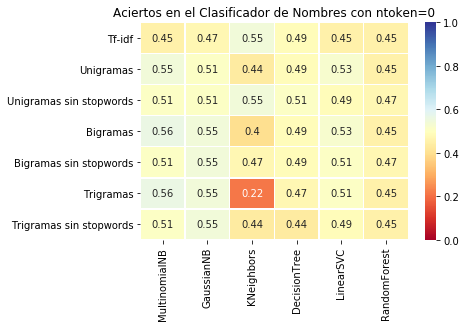

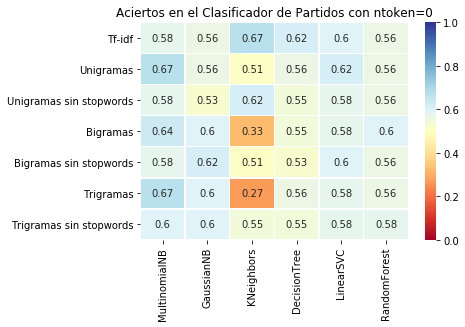

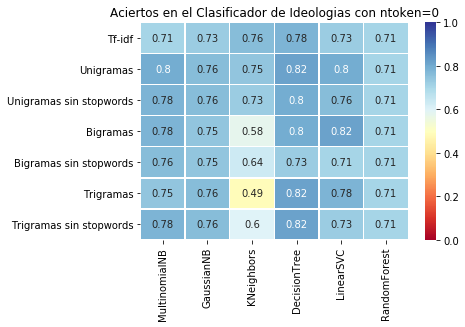

In [8]:
plotAll()

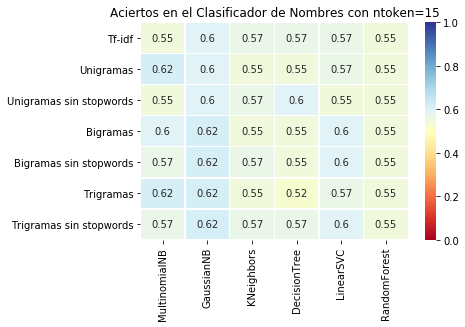

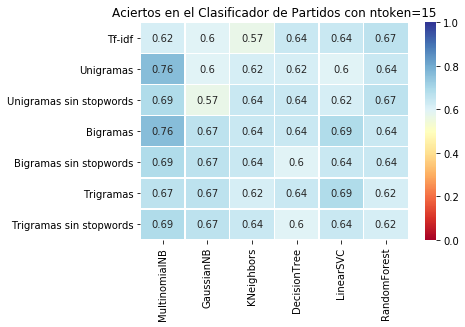

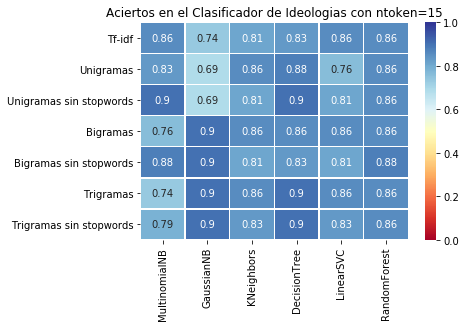

In [9]:
plotAll(ntoken=15)

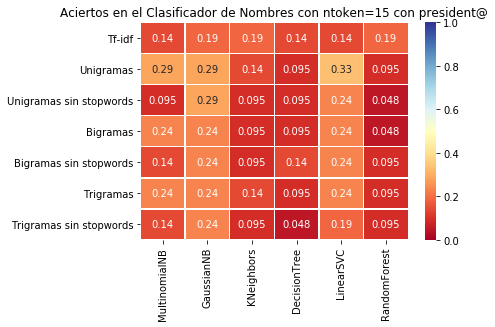

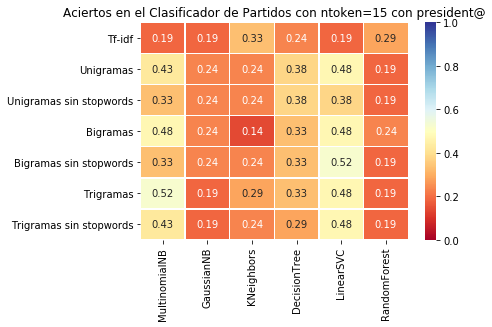

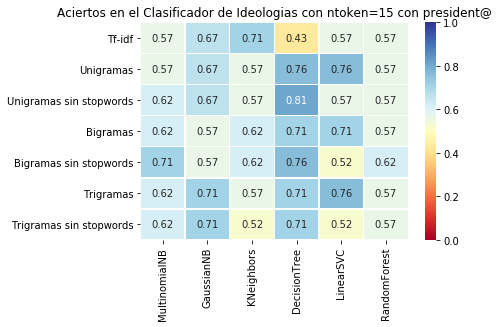

In [10]:
plotAll(ntoken=15, presi='BOSQUET AZNAR')